In [6]:
from datetime import timedelta
import requests_cache

# Create a cached session
session = requests_cache.CachedSession(
    "odds_cache",                    # cache file name
    expire_after=timedelta(hours=1)  # reuse same call for 1 hour
)


In [7]:
#Make sure API key works
from dotenv import load_dotenv
import os

load_dotenv()  # This will read your .env file in the current folder
API_KEY = os.getenv("ODDS_API_KEY")
print(API_KEY)  # Or print(API_KEY[:4] + "…") if you want to hide most of it


738e1e551f9bd42ff77a8363da535a0f


In [8]:
#Test connection
import requests

url = "https://api.the-odds-api.com/v4/sports"
params = {"apiKey": API_KEY}

r = session.get(url, params=params)
print("Status:", r.status_code)
print(r.text[:300])  # Preview first 300 chars


Status: 200
[{"key":"americanfootball_cfl","group":"American Football","title":"CFL","description":"Canadian Football League","active":true,"has_outrights":false},{"key":"americanfootball_ncaaf","group":"American Football","title":"NCAAF","description":"US College Football","active":true,"has_outrights":false},


In [9]:
#See list of markets for nfl

SPORT = "americanfootball_nfl"

url = f"https://api.the-odds-api.com/v4/sports/{SPORT}/odds"
params = {
    "regions": "us",
    "apiKey": API_KEY
}

r = session.get(url, params=params)
games = r.json()

markets_seen = set()

for g in games:
    for b in g.get("bookmakers", []):
        for m in b.get("markets", []):
            markets_seen.add(m.get("key"))

print("Available markets:", markets_seen)


Available markets: {'h2h'}


In [10]:
# One-liner catch

from datetime import timedelta
import requests_cache

# Create a cached session (stores in odds_cache.sqlite locally)
session = requests_cache.CachedSession(
    "odds_cache",
    expire_after=timedelta(hours=1)  # reuse data for 1 hour
)

# Example: fetch mlb odds
SPORT = "baseball_mlb"
url = f"https://api.the-odds-api.com/v4/sports/{SPORT}/odds"
params = {"regions": "us", "markets": "h2h", "apiKey": API_KEY}


r = session.get(url, params=params)
print("From cache?", getattr(r, "from_cache", False))
games = r.json()
print("Games returned:", len(games))


From cache? False
Games returned: 17


In [11]:
#JSON -> Data Frame

import pandas as pd

def normalize_games(games_json, take_first_n_books=3):
    rows = []
    for g in games_json:
        event_id = g["id"]
        start = g.get("commence_time")
        home, away = g["home_team"], g["away_team"]
        for b in g.get("bookmakers", [])[:take_first_n_books]:
            book = b["title"]
            for m in b.get("markets", []):
                if m.get("key") != "h2h":  # only moneyline
                    continue
                for o in m.get("outcomes", []):
                    rows.append({
                        "event_id": event_id,
                        "event_start": start,
                        "home": home,
                        "away": away,
                        "selection": o["name"],
                        "book": book,
                        "price_decimal": float(o["price"]),
                    })
    return pd.DataFrame(rows)

len(games)

df = normalize_games(games, take_first_n_books=10)  # bump to 10 if you want more books
print(df.shape)          # (rows, cols)
df.head(20)              



(206, 7)


,event_id,event_start,home,away,selection,book,price_decimal
0,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Baltimore Orioles,FanDuel,1.07
1,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Seattle Mariners,FanDuel,7.80
2,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Baltimore Orioles,DraftKings,1.06
3,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Seattle Mariners,DraftKings,8.10
4,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Baltimore Orioles,BetMGM,1.09
5,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Seattle Mariners,BetMGM,7.50
6,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Baltimore Orioles,BetRivers,1.05
7,3406dc4194a80b6152139f93aa99e771,2025-08-14T17:06:26Z,Baltimore Orioles,Seattle Mariners,Seattle Mariners,BetRivers,9.00
8,92733ebc332f05097e82c2f456f179da,2025-08-14T19:08:00Z,Toronto Blue Jays,Chicago Cubs,Chicago Cubs,FanDuel,7.00
9,92733ebc332f05097e82c2f456f179da,2025-08-14T19:08:00Z,Toronto Blue Jays,Chicago Cubs,Toronto Blue Jays,FanDuel,1.09


In [12]:
df.head()
df.info()
df.describe()
df['book'].value_counts()
df['selection'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_id       206 non-null    object 
 1   event_start    206 non-null    object 
 2   home           206 non-null    object 
 3   away           206 non-null    object 
 4   selection      206 non-null    object 
 5   book           206 non-null    object 
 6   price_decimal  206 non-null    float64
dtypes: float64(1), object(6)
memory usage: 11.4+ KB


selection
New York Mets            15
Colorado Rockies         14
Arizona Diamondbacks     14
Philadelphia Phillies    14
Washington Nationals     14
Toronto Blue Jays        12
Seattle Mariners         10
Miami Marlins            10
Detroit Tigers            9
Minnesota Twins           9
Atlanta Braves            9
Cleveland Guardians       9
New York Yankees          6
San Francisco Giants      6
Oakland Athletics         6
Los Angeles Angels        6
St. Louis Cardinals       6
Tampa Bay Rays            6
Kansas City Royals        6
Chicago White Sox         6
Texas Rangers             6
Chicago Cubs              6
Baltimore Orioles         4
Boston Red Sox            1
Los Angeles Dodgers       1
San Diego Padres          1
Name: count, dtype: int64

In [13]:
#ODDS logic

best_odds = (
    df.groupby(['event_id', 'selection'])
      .apply(lambda x: x.loc[x['price_decimal'].idxmax()])
      .reset_index(drop=True)
)


arbs = []
for event_id, group in best_odds.groupby('event_id'):
    if len(group) == 2:
        implied_sum = (1 / group['price_decimal']).sum()
        if implied_sum < 1:
            arbs.append({
                'event_id': event_id,
                'home': group.iloc[0]['home'],
                'away': group.iloc[0]['away'],
                'margin': round((1 - implied_sum) * 100, 2)
            })

arbs_df = pd.DataFrame(arbs)
print(arbs_df)




                           event_id               home          away  margin
0  92733ebc332f05097e82c2f456f179da  Toronto Blue Jays  Chicago Cubs    1.67


/var/folders/16/nfdx_v995bg433n655c87s5r0000gn/T/ipykernel_7792/2696254184.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['price_decimal'].idxmax()])


In [14]:
#Features

In [16]:
# Best odds

# === Best MLB moneyline odds per team + "edge vs next-best" + arbitrage, ranked by biggest find ===

import os, pandas as pd
from datetime import datetime, timedelta, timezone
from dotenv import load_dotenv
import requests_cache

# ---------- SETTINGS ----------
SPORT = "baseball_mlb"
MARKETS = "h2h"
REGION = "us"
TIME_WINDOW_PAST_HOURS = 6
TIME_WINDOW_FUTURE_HOURS = 24
TAKE_FIRST_N_BOOKS = None  # None = all books, or set e.g. 10
# ------------------------------

# 0) Auth + cached session (create if you don't already have one)
load_dotenv()
API_KEY = os.getenv("ODDS_API_KEY")
try:
    session
except NameError:
    session = requests_cache.CachedSession("odds_cache", expire_after=timedelta(hours=1))

# helpers
def decimal_to_american(d: float) -> int:
    return int(round((d - 1) * 100)) if d >= 2 else int(round(-100 / (d - 1)))

# 1) Fetch raw odds
url = f"https://api.the-odds-api.com/v4/sports/{SPORT}/odds"
params = {"regions": REGION, "markets": MARKETS, "apiKey": API_KEY}
r = session.get(url, params=params)
r.raise_for_status()
games_json = r.json()

# 2) Normalize JSON -> long DF (one row per book x team)
def normalize_games(games_json, take_first_n_books=TAKE_FIRST_N_BOOKS):
    rows = []
    for g in games_json:
        event_id = g.get("id")
        start = g.get("commence_time")
        home, away = g.get("home_team"), g.get("away_team")
        books_iter = g.get("bookmakers", [])
        if take_first_n_books is not None:
            books_iter = books_iter[:take_first_n_books]
        for b in books_iter:
            book = b.get("title")
            for m in b.get("markets", []):
                if m.get("key") != "h2h":
                    continue
                for o in m.get("outcomes", []):
                    rows.append({
                        "event_id": event_id,
                        "event_start": start,
                        "home": home,
                        "away": away,
                        "selection": o.get("name"),           # team name
                        "book": book,
                        "price_decimal": float(o.get("price")),
                    })
    return pd.DataFrame(rows)

df = normalize_games(games_json)

# 3) Filter to "current" games (started recently or starting soon)
now_utc = datetime.now(timezone.utc)
if not df.empty:
    df["event_start"] = pd.to_datetime(df["event_start"], utc=True)
    mask = (df["event_start"] >= now_utc - timedelta(hours=TIME_WINDOW_PAST_HOURS)) & \
           (df["event_start"] <= now_utc + timedelta(hours=TIME_WINDOW_FUTURE_HOURS))
    df = df.loc[mask].copy()

if df.empty:
    print("No MLB moneyline odds found in the selected time window.")
else:
    # 4) For each (event, team), compute best & next-best + gaps
    edges = []
    for (eid, team), grp in df.groupby(["event_id", "selection"]):
        grp = grp.sort_values("price_decimal", ascending=False).reset_index(drop=True)
        best_row = grp.iloc[0]
        best_price = best_row["price_decimal"]
        best_book = best_row["book"]
        next_best_price = grp["price_decimal"].iloc[1] if len(grp) > 1 else None

        gap = (best_price - next_best_price) if next_best_price else None
        pct_gap = (gap / next_best_price * 100) if next_best_price and next_best_price != 0 else None

        edges.append({
            "event_id": eid,
            "event_start": best_row["event_start"],
            "home": best_row["home"],
            "away": best_row["away"],
            "team": team,
            "best_book": best_book,
            "best_decimal": best_price,
            "best_american": decimal_to_american(best_price),
            "implied_prob": 1.0 / best_price,
            "next_best_decimal": next_best_price,
            "gap_decimal": gap,
            "gap_percent": pct_gap,
        })
    edge_df = pd.DataFrame(edges)

    # 5) Pivot to side-by-side matchup view (home/away columns)
    def pick_side(grp, side_team):
        row = grp.loc[grp["team"] == side_team]
        return row.iloc[0] if not row.empty else None

    rows = []
    for eid, grp in edge_df.groupby("event_id"):
        home_team = grp["home"].iloc[0]
        away_team = grp["away"].iloc[0]
        start = grp["event_start"].iloc[0]

        hr = pick_side(grp, home_team)
        ar = pick_side(grp, away_team)
        if hr is None or ar is None:
            continue

        # arbitrage check with best odds on both sides
        inv_sum = (1.0 / hr["best_decimal"]) + (1.0 / ar["best_decimal"])
        arb_margin = (1 - inv_sum) * 100  # % profit if < 0? Actually >0 means profit margin

        rows.append({
            "event_start": start,
            "home_team": home_team,
            "away_team": away_team,

            "home_best_book": hr["best_book"],
            "home_best_decimal": hr["best_decimal"],
            "home_best_american": hr["best_american"],
            "home_implied_prob": hr["implied_prob"],
            "home_next_best": hr["next_best_decimal"],
            "home_gap_dec": hr["gap_decimal"],
            "home_gap_pct": hr["gap_percent"],

            "away_best_book": ar["best_book"],
            "away_best_decimal": ar["best_decimal"],
            "away_best_american": ar["best_american"],
            "away_implied_prob": ar["implied_prob"],
            "away_next_best": ar["next_best_decimal"],
            "away_gap_dec": ar["gap_decimal"],
            "away_gap_pct": ar["gap_percent"],

            "arb_inverse_sum": inv_sum,
            "arb_margin_pct": arb_margin,  # > 0 => arbitrage exists
        })

    matchups = pd.DataFrame(rows)
    if matchups.empty:
        print("No complete matchups after processing.")
    else:
        # 6) Rank by the biggest % gap across the two sides (your 'best find' metric)
        matchups["max_gap_pct"] = matchups[["home_gap_pct", "away_gap_pct"]].max(axis=1)
        matchups = matchups.sort_values(["max_gap_pct", "event_start"], ascending=[False, True]).reset_index(drop=True)

        # 7) Nicely formatted view
        def fmt_pct(x): 
            return f"{x:.1f}%" if pd.notnull(x) else ""
        def fmt_time(t): 
            return pd.to_datetime(t).strftime("%Y-%m-%d %H:%M UTC")

        display_cols = [
            "event_start","home_team","away_team",
            "home_best_book","home_best_decimal","home_best_american","home_implied_prob","home_next_best","home_gap_pct",
            "away_best_book","away_best_decimal","away_best_american","away_implied_prob","away_next_best","away_gap_pct",
            "arb_inverse_sum","arb_margin_pct","max_gap_pct"
        ]
        styled = (
            matchups[display_cols]
            .style
            .format({
                "event_start": fmt_time,
                "home_best_decimal": "{:.2f}",
                "away_best_decimal": "{:.2f}",
                "home_best_american": "{:+d}",
                "away_best_american": "{:+d}",
                "home_implied_prob": "{:.2%}",
                "away_implied_prob": "{:.2%}",
                "home_next_best": lambda x: "" if pd.isna(x) else f"{x:.2f}",
                "away_next_best": lambda x: "" if pd.isna(x) else f"{x:.2f}",
                "home_gap_pct": fmt_pct,
                "away_gap_pct": fmt_pct,
                "arb_inverse_sum": "{:.3f}",
                "arb_margin_pct": lambda x: f"{x:.2f}%" if pd.notnull(x) else "",
                "max_gap_pct": fmt_pct,
            })
            .hide(axis="index")
        )

        print(f"From cache? {getattr(r, 'from_cache', False)} | Games covered: {matchups.shape[0]}")
        styled
from IPython.display import display
display(styled)


From cache? True | Games covered: 7


event_start,home_team,away_team,home_best_book,home_best_decimal,home_best_american,home_implied_prob,home_next_best,home_gap_pct,away_best_book,away_best_decimal,away_best_american,away_implied_prob,away_next_best,away_gap_pct,arb_inverse_sum,arb_margin_pct,max_gap_pct
2025-08-14 19:08 UTC,Toronto Blue Jays,Chicago Cubs,BetMGM,1.16,-625,86.21%,1.14,1.8%,MyBookie.ag,8.25,+725,12.12%,7.00,17.9%,0.983,1.67%,17.9%
2025-08-14 17:06 UTC,Baltimore Orioles,Seattle Mariners,BetMGM,1.09,-1111,91.74%,1.07,1.9%,BetRivers,9.00,+800,11.11%,8.10,11.1%,1.029,-2.85%,11.1%
2025-08-14 23:41 UTC,Minnesota Twins,Detroit Tigers,BetRivers,2.75,+175,36.36%,2.72,1.1%,LowVig.ag,1.57,-175,63.69%,1.57,0.0%,1.001,-0.06%,1.1%
2025-08-14 22:46 UTC,Washington Nationals,Philadelphia Phillies,BetMGM,2.65,+165,37.74%,2.63,0.8%,BetUS,1.56,-179,64.10%,1.55,0.6%,1.018,-1.84%,0.8%
2025-08-14 23:10 UTC,New York Mets,Atlanta Braves,BetUS,1.58,-172,63.29%,1.57,0.6%,LowVig.ag,2.60,+160,38.46%,2.60,0.0%,1.018,-1.75%,0.6%
2025-08-14 22:41 UTC,Cleveland Guardians,Miami Marlins,BetUS,1.85,-118,54.05%,1.84,0.5%,LowVig.ag,2.14,+114,46.73%,2.14,0.0%,1.008,-0.78%,0.5%
2025-08-15 00:41 UTC,Colorado Rockies,Arizona Diamondbacks,LowVig.ag,2.50,+150,40.00%,2.50,0.0%,LowVig.ag,1.60,-167,62.50%,1.60,0.0%,1.025,-2.50%,0.0%


In [17]:
if matchups.empty:
    print("No complete matchups after processing.")
else:
    # Rank by biggest % gap on either side
    matchups["max_gap_pct"] = matchups[["home_gap_pct", "away_gap_pct"]].max(axis=1)
    matchups = matchups.sort_values(["max_gap_pct", "event_start"], ascending=[False, True]).reset_index(drop=True)

    # Columns to show (choose & order once)
    display_cols = [
        "event_start","home_team","away_team",
        "home_best_book","home_best_decimal","home_best_american","home_implied_prob","home_next_best","home_gap_pct",
        "away_best_book","away_best_decimal","away_best_american","away_implied_prob","away_next_best","away_gap_pct",
        "arb_inverse_sum","arb_margin_pct","max_gap_pct"
    ]

    # Render (format only; no new columns created)
    def fmt_pct(x): 
        return f"{x:.1f}%" if pd.notnull(x) else ""
    def fmt_time(t): 
        return pd.to_datetime(t).strftime("%Y-%m-%d %H:%M UTC")

    styled = (
        matchups[display_cols]
        .style
        .format({
            "event_start": fmt_time,
            "home_best_decimal": "{:.2f}",
            "away_best_decimal": "{:.2f}",
            "home_best_american": "{:+d}",
            "away_best_american": "{:+d}",
            "home_implied_prob": "{:.2%}",
            "away_implied_prob": "{:.2%}",
            "home_next_best": lambda x: "" if pd.isna(x) else f"{x:.2f}",
            "away_next_best": lambda x: "" if pd.isna(x) else f"{x:.2f}",
            "home_gap_pct": fmt_pct,
            "away_gap_pct": fmt_pct,
            "arb_inverse_sum": "{:.3f}",
            "arb_margin_pct": lambda x: f"{x:.2f}%" if pd.notnull(x) else "",
            "max_gap_pct": fmt_pct,
        })
        .hide(axis="index")
    )

    print(f"From cache? {getattr(r, 'from_cache', False)} | Games covered: {matchups.shape[0]}")
    styled  # let Jupyter render
styled

From cache? True | Games covered: 7


event_start,home_team,away_team,home_best_book,home_best_decimal,home_best_american,home_implied_prob,home_next_best,home_gap_pct,away_best_book,away_best_decimal,away_best_american,away_implied_prob,away_next_best,away_gap_pct,arb_inverse_sum,arb_margin_pct,max_gap_pct
2025-08-14 19:08 UTC,Toronto Blue Jays,Chicago Cubs,BetMGM,1.16,-625,86.21%,1.14,1.8%,MyBookie.ag,8.25,+725,12.12%,7.00,17.9%,0.983,1.67%,17.9%
2025-08-14 17:06 UTC,Baltimore Orioles,Seattle Mariners,BetMGM,1.09,-1111,91.74%,1.07,1.9%,BetRivers,9.00,+800,11.11%,8.10,11.1%,1.029,-2.85%,11.1%
2025-08-14 23:41 UTC,Minnesota Twins,Detroit Tigers,BetRivers,2.75,+175,36.36%,2.72,1.1%,LowVig.ag,1.57,-175,63.69%,1.57,0.0%,1.001,-0.06%,1.1%
2025-08-14 22:46 UTC,Washington Nationals,Philadelphia Phillies,BetMGM,2.65,+165,37.74%,2.63,0.8%,BetUS,1.56,-179,64.10%,1.55,0.6%,1.018,-1.84%,0.8%
2025-08-14 23:10 UTC,New York Mets,Atlanta Braves,BetUS,1.58,-172,63.29%,1.57,0.6%,LowVig.ag,2.60,+160,38.46%,2.60,0.0%,1.018,-1.75%,0.6%
2025-08-14 22:41 UTC,Cleveland Guardians,Miami Marlins,BetUS,1.85,-118,54.05%,1.84,0.5%,LowVig.ag,2.14,+114,46.73%,2.14,0.0%,1.008,-0.78%,0.5%
2025-08-15 00:41 UTC,Colorado Rockies,Arizona Diamondbacks,LowVig.ag,2.50,+150,40.00%,2.50,0.0%,LowVig.ag,1.60,-167,62.50%,1.60,0.0%,1.025,-2.50%,0.0%


In [18]:
#Personalized filters

import pandas as pd

# Make sure event_start is datetime (UTC)
matchups["event_start"] = pd.to_datetime(matchups["event_start"], utc=True)

# Favorite/underdog flags based on implied probability (lower decimal -> higher prob)
matchups["home_is_favorite"] = matchups["home_implied_prob"] > matchups["away_implied_prob"]
matchups["away_is_favorite"] = ~matchups["home_is_favorite"]

from datetime import datetime, timedelta, timezone

def filter_matchups(
    df: pd.DataFrame,
    *,
    include_books: set | None = None,          # e.g., {"DraftKings","FanDuel"}
    exclude_books: set | None = None,          # e.g., {"LowVig.ag"}
    min_decimal: float | None = None,          # e.g., 2.0 (only show >= 2.0)
    max_decimal: float | None = None,          # e.g., 5.0
    team_contains: str | None = None,          # e.g., "Yankees"
    start_from: datetime | None = None,        # e.g., datetime.now(timezone.utc)
    start_to: datetime | None = None,          # e.g., datetime.now(timezone.utc)+timedelta(hours=12)
    min_arb_margin_pct: float | None = None,   # e.g., 0.25 (only show opportunities > 0.25%)
    only_favorites: bool | None = None,        # True (favorites only), False (underdogs only), None (both)
) -> pd.DataFrame:
    view = df.copy()

    # --- time window ---
    if start_from is not None:
        view = view[view["event_start"] >= start_from]
    if start_to is not None:
        view = view[view["event_start"] <= start_to]

    # --- sportsbooks include/exclude ---
    if include_books:
        view = view[(view["home_best_book"].isin(include_books)) | (view["away_best_book"].isin(include_books))]
    if exclude_books:
        view = view[(~view["home_best_book"].isin(exclude_books)) & (~view["away_best_book"].isin(exclude_books))]

    # --- odds thresholds (apply to either side’s best odds) ---
    if min_decimal is not None:
        view = view[(view["home_best_decimal"] >= min_decimal) | (view["away_best_decimal"] >= min_decimal)]
    if max_decimal is not None:
        view = view[(view["home_best_decimal"] <= max_decimal) | (view["away_best_decimal"] <= max_decimal)]

    # --- team substring ---
    if team_contains:
        s = team_contains.strip()
        view = view[
            view["home_team"].str.contains(s, case=False, na=False) |
            view["away_team"].str.contains(s, case=False, na=False)
        ]

    # --- arbitrage threshold ---
    if min_arb_margin_pct is not None:
        view = view[view["arb_margin_pct"] >= min_arb_margin_pct]

    # --- favorites / underdogs toggle ---
    if only_favorites is True:
        view = view[(view["home_is_favorite"]) | (view["away_is_favorite"])]
    elif only_favorites is False:
        view = view[(~view["home_is_favorite"]) | (~view["away_is_favorite"])]

    # keep your ranking (max_gap_pct desc, then by time)
    if "max_gap_pct" in view.columns:
        view = view.sort_values(["max_gap_pct", "event_start"], ascending=[False, True]).reset_index(drop=True)
    else:
        view = view.sort_values(["event_start"]).reset_index(drop=True)

    return view


In [19]:
# A) Show next 12 hours, any book, underdogs (>= 2.0), no arb filter
filtered = filter_matchups(
    matchups,
    start_from=datetime.now(timezone.utc),
    start_to=datetime.now(timezone.utc) + timedelta(hours=12),
    min_decimal=2.0
)
filtered.head()


,event_start,home_team,away_team,home_best_book,home_best_decimal,home_best_american,home_implied_prob,home_next_best,home_gap_dec,home_gap_pct,...,away_best_american,away_implied_prob,away_next_best,away_gap_dec,away_gap_pct,arb_inverse_sum,arb_margin_pct,max_gap_pct,home_is_favorite,away_is_favorite
0,2025-08-14 23:41:00+00:00,Minnesota Twins,Detroit Tigers,BetRivers,2.75,175,0.363636,2.72,0.03,1.102941,...,-175,0.636943,1.57,0.00,0.000000,1.000579,-0.057904,1.102941,False,True
1,2025-08-14 22:46:00+00:00,Washington Nationals,Philadelphia Phillies,BetMGM,2.65,165,0.377358,2.63,0.02,0.760456,...,-179,0.641026,1.55,0.01,0.645161,1.018384,-1.838413,0.760456,False,True
2,2025-08-14 23:10:00+00:00,New York Mets,Atlanta Braves,BetUS,1.58,-172,0.632911,1.57,0.01,0.636943,...,160,0.384615,2.60,0.00,0.000000,1.017527,-1.752678,0.636943,True,False
3,2025-08-14 22:41:00+00:00,Cleveland Guardians,Miami Marlins,BetUS,1.85,-118,0.540541,1.84,0.01,0.543478,...,114,0.467290,2.14,0.00,0.000000,1.007830,-0.783026,0.543478,True,False
4,2025-08-15 00:41:00+00:00,Colorado Rockies,Arizona Diamondbacks,LowVig.ag,2.50,150,0.400000,2.50,0.00,0.000000,...,-167,0.625000,1.60,0.00,0.000000,1.025000,-2.500000,0.000000,False,True


In [20]:
#Bankroll and stake split column

import pandas as pd
import numpy as np

def add_bankroll_splits(
    df: pd.DataFrame,
    bankroll: float = 100.0,
    only_arbs: bool = True,           # keep only rows with arb_margin_pct > 0
    min_profit_pct: float | None = None  # e.g., 0.2 means require >= 0.2% profit
) -> pd.DataFrame:
    """Add stake split, equal payout, profit & ROI columns based on best home/away decimal odds."""

    view = df.copy()

    # Guard: need both sides’ best odds
    required = {"home_best_decimal", "away_best_decimal"}
    if not required.issubset(view.columns):
        raise ValueError(f"matchups is missing columns: {required - set(view.columns)}")

    # Compute inverse sum & arb margin if not already present
    if "arb_inverse_sum" not in view.columns:
        view["arb_inverse_sum"] = (1.0 / view["home_best_decimal"]) + (1.0 / view["away_best_decimal"])
    if "arb_margin_pct" not in view.columns:
        view["arb_margin_pct"] = (1 - view["arb_inverse_sum"]) * 100

    d1 = view["home_best_decimal"].astype(float)
    d2 = view["away_best_decimal"].astype(float)
    denom = (d1 + d2)

    # Stake split for equal payout (valid when denom > 0)
    view["stake_home"] = bankroll * (d2 / denom)
    view["stake_away"] = bankroll * (d1 / denom)

    # Equal payout on either outcome; profit & ROI
    view["equal_payout"] = view["stake_home"] * d1  # == stake_away * d2
    view["profit_$"] = view["equal_payout"] - bankroll
    view["profit_%"] = np.where(bankroll > 0, (view["profit_$"] / bankroll) * 100, np.nan)

    # (Optional) keep only true arbs
    if only_arbs:
        view = view[view["arb_margin_pct"] > 0]
    if min_profit_pct is not None:
        view = view[view["profit_%"] >= min_profit_pct]

    # tidy / order
    cols_front = [
        "event_start","home_team","away_team",
        "home_best_book","home_best_decimal","away_best_book","away_best_decimal",
        "arb_inverse_sum","arb_margin_pct",
        "stake_home","stake_away","equal_payout","profit_$","profit_%"
    ]
    # keep any that exist; tolerate missing
    cols_front = [c for c in cols_front if c in view.columns]
    other_cols = [c for c in view.columns if c not in cols_front]
    view = view[cols_front + other_cols].reset_index(drop=True)

    return view
bankroll = 100.0
arb_view = add_bankroll_splits(matchups, bankroll=bankroll, only_arbs=True, min_profit_pct=None)
arb_view.head()


,event_start,home_team,away_team,home_best_book,home_best_decimal,away_best_book,away_best_decimal,arb_inverse_sum,arb_margin_pct,stake_home,...,home_gap_dec,home_gap_pct,away_best_american,away_implied_prob,away_next_best,away_gap_dec,away_gap_pct,max_gap_pct,home_is_favorite,away_is_favorite
0,2025-08-14 19:08:00+00:00,Toronto Blue Jays,Chicago Cubs,BetMGM,1.16,MyBookie.ag,8.25,0.983281,1.671891,87.672689,...,0.02,1.754386,725,0.121212,7.0,1.25,17.857143,17.857143,True,False


In [21]:
# Live graphing

import os, time, json, pandas as pd
from datetime import datetime, timezone, timedelta
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

SPORT = "baseball_mlb"   # or "americanfootball_nfl"
MARKETS = "h2h"
REGION = "us"
HISTORY_CSV = "snapshots/mlb_h2h_history.csv"

# Ensure folder exists
os.makedirs(os.path.dirname(HISTORY_CSV), exist_ok=True)

def fetch_raw_odds(session, api_key, sport=SPORT, market=MARKETS, region=REGION, expire_after=0):
    """Fetch one snapshot; expire_after=0 bypasses cache for fresh data."""
    url = f"https://api.the-odds-api.com/v4/sports/{sport}/odds"
    params = {"regions": region, "markets": market, "apiKey": api_key}
    r = session.get(url, params=params, expire_after=expire_after)
    r.raise_for_status()
    return r.json()

def normalize_h2h(games_json, take_first_n_books=None):
    rows = []
    for g in games_json:
        eid = g.get("id")
        start = g.get("commence_time")
        home, away = g.get("home_team"), g.get("away_team")
        books = g.get("bookmakers", [])
        if take_first_n_books is not None:
            books = books[:take_first_n_books]
        for b in books:
            book = b.get("title")
            for m in b.get("markets", []):
                if m.get("key") != "h2h": 
                    continue
                for o in m.get("outcomes", []):
                    rows.append({
                        "event_id": eid,
                        "event_start": start,
                        "home": home,
                        "away": away,
                        "selection": o.get("name"),
                        "book": book,
                        "price_decimal": float(o.get("price")),
                    })
    return pd.DataFrame(rows)

def log_snapshot(session, api_key, sport=SPORT):
    """Fetch → normalize → append timestamped rows to HISTORY_CSV."""
    run_ts = datetime.now(timezone.utc).isoformat()
    raw = fetch_raw_odds(session, api_key, sport=sport, market="h2h", region=REGION, expire_after=0)
    df = normalize_h2h(raw)
    if df.empty:
        return df
    df["event_start"] = pd.to_datetime(df["event_start"], utc=True)
    df["run_ts"] = run_ts
    header = not os.path.exists(HISTORY_CSV)
    df.to_csv(HISTORY_CSV, mode="a", index=False, header=header)
    return df

def load_history():
    if not os.path.exists(HISTORY_CSV):
        return pd.DataFrame()
    hist = pd.read_csv(HISTORY_CSV)
    if not hist.empty:
        hist["event_start"] = pd.to_datetime(hist["event_start"], utc=True, errors="coerce")
        hist["run_ts"] = pd.to_datetime(hist["run_ts"], utc=True, errors="coerce")
    return hist

def select_event_recent(hist, hours_window=24):
    """Return the most recent event_id in the next/past window (helper)."""
    now = datetime.now(timezone.utc)
    mask = (hist["event_start"] >= now - timedelta(hours=6)) & (hist["event_start"] <= now + timedelta(hours=hours_window))
    subset = hist.loc[mask]
    if subset.empty:
        return None
    # pick event with most rows in recent snapshots
    return subset["event_id"].value_counts().idxmax()

def plot_best_over_time(hist, event_id):
    """Plot the best decimal price over time for each team in event_id."""
    data = hist[hist["event_id"] == event_id].copy()
    if data.empty:
        print("No history for that event yet.")
        return

    # Compute best price per run_ts per team
    grp = (data.groupby(["run_ts", "selection"])["price_decimal"]
              .max()
              .reset_index())

    # Pivot to two lines: one per team
    wide = grp.pivot(index="run_ts", columns="selection", values="price_decimal").sort_index()
    if wide.empty:
        print("No lines to plot.")
        return

    # Single clean timeseries plot
    plt.figure(figsize=(9,4.5))
    plt.plot(wide.index, wide.iloc[:, 0], label=wide.columns[0])
    if wide.shape[1] > 1:
        plt.plot(wide.index, wide.iloc[:, 1], label=wide.columns[1])
    plt.legend()
    plt.title("Best Moneyline (Decimal) Over Time")
    plt.xlabel("Snapshot time (UTC)")
    plt.ylabel("Best decimal odds")
    plt.tight_layout()
    display(plt.gcf())
    plt.close()


In [22]:
import sys
print(sys.executable)


/Users/elliotdescarpentrie/sports_odds/.venv/bin/python


In [23]:
print(requests_cache.__version__)


1.2.1


In [24]:
import sys
!{sys.executable} -m pip install matplotlib



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [25]:
df_now = log_snapshot(session, API_KEY, sport=SPORT)
print("Snapshot rows:", 0 if df_now is None else len(df_now))


Snapshot rows: 206


In [26]:
hist = load_history()
event_to_watch = select_event_recent(hist, hours_window=24)
print("Watching event:", event_to_watch)


Watching event: a3b6b094b903ef84efd4e8e1cad60fd3


Live refresh #1 @ 21:11:34 UTC


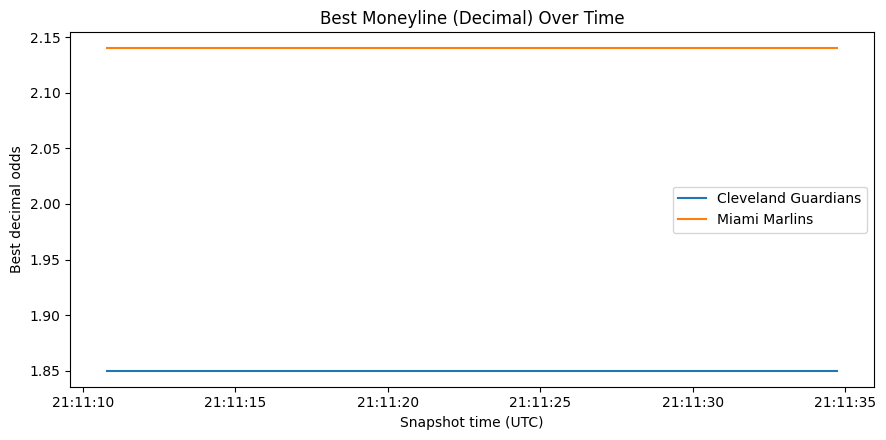

KeyboardInterrupt: 

In [27]:
# Poll every 60–120s to avoid burning quota. Keep this short while testing.
POLL_SECONDS = 90
ITERATIONS = 15  # ~22 minutes at 90s intervals

for i in range(ITERATIONS):
    # fetch fresh (expire_after=0 in fetch_raw_odds) and append to CSV
    log_snapshot(session, API_KEY, sport=SPORT)

    # reload & replot
    hist = load_history()
    clear_output(wait=True)
    print(f"Live refresh #{i+1} @ {datetime.now(timezone.utc).strftime('%H:%M:%S UTC')}")
    plot_best_over_time(hist, event_to_watch)

    time.sleep(POLL_SECONDS)
